## Import Libraries

In [74]:
import torch
from torch import  nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets, transforms

import time
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import copy

## Set path to drive to load/save data


In [75]:
use_drive=True
if use_drive:
  from google.colab import drive
  drive.mount('/content/drive')
# set the path to load/save models
path_to_files="drive/MyDrive/OptML_project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
'''
Generate MNIST train and test data.
RETURN:
    - trainset: 60000 train samples
    - testset: 10000 test samples
'''
def generate_data():
    transform = transforms.ToTensor()

    # Load and transform data
    trainset = datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    testset = datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    return trainset, testset

In [77]:
class LeNet5(torch.nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        #First convolution (LeNet5 us 32x32 image as input hence the padding of 2)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        #First Max-Pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        #Second convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        #Second Max-Pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)

        #Fully Connected Layers
        self.fc1 = torch.nn.Linear(16*5*5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Do the convolution and then perform ReLu
        x = torch.nn.functional.relu(self.conv1(x))
        # Max-Pooling with 2x2 grid
        x = self.max_pool_1(x)
        # Do the second convolution and then ReLu
        x = torch.nn.functional.relu(self.conv2(x))
        # Max-Pooling with 2x2 grid
        x = self.max_pool_2(x)
        # Flatten to have 16*5*5 columns, FC1 and then ReLu
        x = torch.nn.functional.relu(self.fc1(x.view(-1, 16*5*5)))
        # FC2 then ReLu
        x = torch.nn.functional.relu(self.fc2(x))
        #FC3
        x = self.fc3(x)

        return x

In [78]:
optimizer_methods = {'SGD': (lambda parameters, eta, momentum: optim.SGD(parameters(), eta, momentum = momentum))}

In [79]:
'''
The train_model method will train the model according to the given parameters and it
will store the results after each epoch, like the train/test accuracy and train/test loss

PARAMETERS:
    - model: nn model
    - trainset: training set
    - testset: testing set
    - batch_size: size of the batch used during training
    - eta: learning rate
    - criterion: nn loss
    - nb_epochs: number of epochs used during training
    - momentum: value of the momentum used
    - optimizer_name: string corresponding to the optimizer name
    - device: torch.device "cuda" if using GPU or "cpu" when not
    - results: empty results list
    - warmup : when set to True will perform the gradual warmup
    
'''
def train_model(model, trainset, testset, batch_size, eta, criterion,
                nb_epochs, momentum, optimizer_name, device, results,warmup=False):

    NB_TRAIN_SAMPLES = len(trainset)
    NB_TEST_SAMPLES = len(testset)
    TOT_TIME = 0


    # default pytorch functions which are useful for loading testing and training data
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=NB_TEST_SAMPLES)

    optimizer = optimizer_methods[optimizer_name](model.parameters, eta, momentum)

    for epoch in range(nb_epochs):
        if epoch%5==0:
          print('Epoch :',epoch)
        curr_train_acc = 0
        start_time = time.time()

        if (epoch<9 and warmup):
          print(epoch)
          k=10
          ep=epoch+1
          u_eta = ((k+1-ep)/k)*eta + ((ep-1)*batch_size*eta)/(k*64.0)
          optimizer = optimizer_methods[optimizer_name](model.parameters, u_eta, momentum)


        if (epoch == 9) and (warmup):
            print(epoch)
            u_eta = eta*(batch_size/64.0)
            optimizer = optimizer_methods[optimizer_name](model.parameters, u_eta, momentum)
        
        

        for minibatch, label in train_loader:
            minibatch, label = minibatch.to(device), label.to(device)
            output = model.forward(minibatch)
            _, pred_class = output.max(1)
            loss = criterion(output, label)
            # Backward and optimize
            model.zero_grad()
            loss.backward()
            optimizer.step()
            curr_train_acc += (label == pred_class).sum().item()

        duration = time.time() - start_time
        TOT_TIME += duration
        train_loss = loss.item()
        # Testing part
        with torch.no_grad():
            testset, test_labels = next(iter(test_loader))  # load the one and only test batch
            testset, test_labels = testset.to(device), test_labels.to(device)

            output = model.forward(testset)
            loss = criterion(output, test_labels)

            test_loss = loss.item()
            _, pred_class = output.max(1)

            curr_test_acc = (test_labels == pred_class).sum().item()

        # Append the epoch data to results
        results.append({'model': 'LeNet5',
                        'train_accuracy': curr_train_acc/NB_TRAIN_SAMPLES, 'test_accuracy': curr_test_acc/NB_TEST_SAMPLES,
                        'train_loss': train_loss, 'test_loss': test_loss, 'epoch': epoch + 1,
                        'time': duration, 'batch_size': batch_size,
                        'lr': eta,'momentum':momentum})

    print(f'MODEL: {"LeNet5"}, BATCH_SIZE: {batch_size}, TIME : {TOT_TIME}, CRITERION: {str(criterion)}, EPOCHS: {nb_epochs}, train_accuracy:{curr_train_acc/NB_TRAIN_SAMPLES}, test_accuracy: {curr_test_acc/NB_TEST_SAMPLES}')

In [80]:
def sqrtScaleRule(n0,b0,batchlist):
  bs_lr=[]
  for b in batchlist:
    lr = n0*(np.sqrt(b/float(b0)))
    bs_lr.append((b,lr))
  return bs_lr

def linearScaleRule(n0,b0,batchlist):
  bs_lr=[]
  for b in batchlist:
    lr = n0*(b/float(b0))
    bs_lr.append((b,lr))
  return bs_lr

In [81]:
def main():

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(device)
    print('Training model on different batch size values ...')

    # Effect of batch size
    batch_size_values = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
    eta = 0.01
    epochs=30
    model = LeNet5()
    results = []
    for batch in batch_size_values:
        trainset, testset = generate_data()
        model_cloned=copy.deepcopy(model)
        train_model(model_cloned.to(device), trainset, testset, batch, eta,
                    nn.CrossEntropyLoss(), epochs, 0, 'SGD', device, results,warmup=False)
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(path_to_files+'BaseLeNet5.csv')

    ''' Uncomment this to run our model with the sqrt scaling rule
    eta = 0.01
    bs_lr = sqrtScaleRule(eta,64,batch_size_values)

    epochs=30
    model = LeNet5()
    results = []
    for bl in b:
        trainset, testset = generate_data()
        model_cloned=copy.deepcopy(model)
        train_model(model_cloned.to(device), trainset, testset, bl[0], bl[1],
                    nn.CrossEntropyLoss(), epochs, 0, 'SGD', device, results,warmup=False)
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(path_to_files+'sqrtLrLeNet5.csv')
    '''
    






In [82]:
main()

cpu
Training model on different batch size values ...
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Epoch : 0


KeyboardInterrupt: ignored

In [71]:
df_base = pd.read_csv(path_to_files+'BaseLeNet5.csv')

In [72]:
def plot(results):
  colors = {64: 'tab:blue', 128: 'tab:orange', 256: 'tab:green', 512: 'tab:red', 1024: 'tab:purple', 2048 : 'tab:brown', 4096: 'tab:pink', 8192: 'tab:gray'}
  fig, axs = plt.subplots(1, 2)
  fig.tight_layout()
  results = results.set_index('epoch')

  group_batch = results.groupby(['batch_size'])
  for batch, df in group_batch:

        df['train_accuracy'].plot(ax = axs[0], color=colors[batch])
        axs[0].set_title('Train accuracy')
        axs[0].set(ylabel='Accuracy')

        df['test_accuracy'].plot(ax = axs[1], color=colors[batch], label=str(df['batch_size'].unique()[0]))
        axs[1].set_title('Test accuracy')
        axs[1].set(ylabel='Accuracy')
        axs[1].yaxis.set_label_text("")
        axs[1].legend(title ='Batch Size',bbox_to_anchor=(1.05, 1),loc='upper left')
        '''
        df['train_loss'].plot(ax = axs[1, 0], color=colors[batch])
        axs[1, 0].set_title('Train loss')
        axs[1, 0].set(xlabel='Epoch', ylabel='Loss')

        df['test_loss'].plot(ax = axs[1, 1], color=colors[batch])
        axs[1, 1].set_title('Test loss')
        axs[1, 1].set(xlabel='Epoch', ylabel='Loss')
        axs[1, 1].yaxis.set_label_text("")
        '''

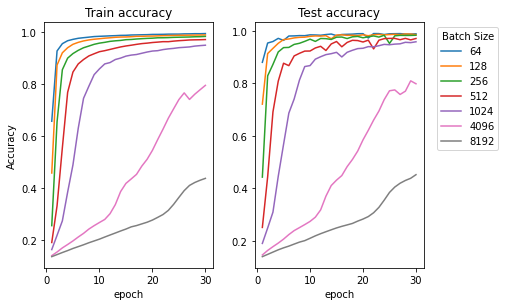

In [73]:
plot(df_base)